On downloaded GEFSv12 reforecast data, preprocess IVT and freezing level

In [42]:
# Import Python modules
import os, sys
import yaml
import numpy as np
import pandas as  pd
import xarray as xr
from scipy.integrate import trapz

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras


# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

In [2]:
ARID = "201508151811" # AR track ID
date = "2015081700"

var_array = (
'apcp_sfc', ## Total Precipitation 
'ugrd_pres', ## U below 700 mb
'ugrd_pres_abv700mb', ## U above 700 mb
'vgrd_pres', ## V below 700 mb
'vgrd_pres_abv700mb', ## V above 700 mb
'tmp_pres', ## T below 700 mb
'tmp_pres_abv700mb', ## T above 700 mb
'spfh_pres', ## Q below 700 mb
'spfh_pres_abv700mb', ## Q above 700 mb
'hgt_pres', ## Z below 700 mb
'hgt_pres_abv700mb', ## Z above 700 mb
)

In [3]:
path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/{0}/'.format(ARID)      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [37]:
def read_and_regrid_prs_var(varname):
    '''
    Using xarray, reads grib data for given variable for above and below 700 mb
    Regrids the data above 700 mb to same horizontal resolution as data below 700 mb
    Merges regridded data and data below 700 mb to single dataset
    
    returns: ds
        xarray dataset of variable at 0.25 degree horizonal resolution at all given pressure levels
    '''
    
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/{0}/'.format(ARID) 
    date = "2015081700"
    
    # read data below 700 mb - 0.25 degree
    fname = path_to_data+"{0}_pres_{1}_c00.grib2".format(varname, date)
    ds_below = xr.open_dataset(fname, engine='cfgrib')
    
    # read data above 700 mb - 0.5 degree
    fname = path_to_data+"{0}_pres_abv700mb_{1}_c00.grib2".format(varname, date)
    ds_above = xr.open_dataset(fname, engine='cfgrib')
    
    ## regrid ds_above to same horizontal resolution as ds_below
    regrid_lats = ds_below.latitude.values
    regrid_lons = ds_below.longitude.values
    ds_above = ds_above.interp(longitude=regrid_lons, latitude=regrid_lats)
    
    ## concatenate into single ds
    ds = xr.concat([ds_above, ds_below], dim='isobaricInhPa')
    
    ## subset to N. Pacific [0, 70, 140, 295]
    ds = ds.sel(latitude=slice(70, 0), longitude=slice(140, 295))
    
    return ds


def calc_IVT(ds):
    '''
    Using xarray and preprocessed grib data, calculate IVT
    
    returns: ds
        xarray ds with IVTu, IVTv, and IVT at 0.25 degree
    '''

    # integrate water vapor transport and water vapor
    pressure = ds.isobaricInhPa.values*100 # convert from hPa to Pa
    pressure = np.reshape(pressure, (1, len(pressure), 1, 1))
    g = -9.81 # gravity constant
    ivtu = trapz(ds.u*ds.q, pressure, axis=1)/g
    ivtv = trapz(ds.v*ds.q, pressure, axis=1)/g
    ivt = np.sqrt(ivtu**2 + ivtv**2)
    
    # put into a dataset
    time = ds.valid_time.values
    lat = ds.latitude.values
    lon = ds.longitude.values

    var_dict = {'ivtu': (['time', 'lat', 'lon'], ivtu),
                'ivtv': (['time', 'lat', 'lon'], ivtv), 
                'ivt': (['time', 'lat', 'lon'], ivt)}
    ds = xr.Dataset(var_dict,
                    coords={'time': (['time'], time),
                            'lat': (['lat'], lat),
                            'lon': (['lon'], lon)})
    
    return ds


In [5]:
%%time
## for calculating IVT
varname_lst = ['ugrd', 'vgrd', 'spfh']
ds_lst = []
for i, varname in enumerate(varname_lst):
    ds = read_and_regrid_prs_var(varname)
    ds_lst.append(ds)

ds = xr.merge(ds_lst) # merge u, v, and q into single ds
ds = ds.sel(isobaricInhPa=slice(300, 1000))

ds

CPU times: user 3min 33s, sys: 2min 18s, total: 5min 52s
Wall time: 5min 56s


<xarray.Dataset>
Dimensions:        (step: 80, isobaricInhPa: 12, longitude: 621, latitude: 281)
Coordinates:
  * step           (step) timedelta64[ns] 0 days 03:00:00 ... 10 days 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 300.0 400.0 500.0 ... 975.0 1e+03
  * longitude      (longitude) float64 140.0 140.2 140.5 ... 294.5 294.8 295.0
  * latitude       (latitude) float64 70.0 69.75 69.5 69.25 ... 0.5 0.25 0.0
    number         int64 0
    time           datetime64[ns] 2015-08-17
    valid_time     (step) datetime64[ns] 2015-08-17T03:00:00 ... 2015-08-27
Data variables:
    u              (step, isobaricInhPa, latitude, longitude) float64 13.03 ....
    v              (step, isobaricInhPa, latitude, longitude) float64 -6.321 ...
    q              (step, isobaricInhPa, latitude, longitude) float64 6e-05 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-07-26T14:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [54]:
%%time
ds_IVT = calc_IVT(ds) # calculate IVT


CPU times: user 2.93 s, sys: 3.92 s, total: 6.85 s
Wall time: 6.85 s


In [72]:
ds_IVT

<xarray.Dataset>
Dimensions:  (time: 80, lat: 281, lon: 621)
Coordinates:
  * time     (time) datetime64[ns] 2015-08-17T03:00:00 ... 2015-08-27
  * lat      (lat) float64 70.0 69.75 69.5 69.25 69.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float64 140.0 140.2 140.5 140.8 ... 294.2 294.5 294.8 295.0
Data variables:
    ivtu     (time, lat, lon) float64 -18.63 -16.82 -15.33 ... 318.8 332.3 332.1
    ivtv     (time, lat, lon) float64 -72.53 -73.05 -73.26 ... 54.16 55.74 49.38
    ivt      (time, lat, lon) float64 74.88 74.97 74.85 ... 323.4 336.9 335.8

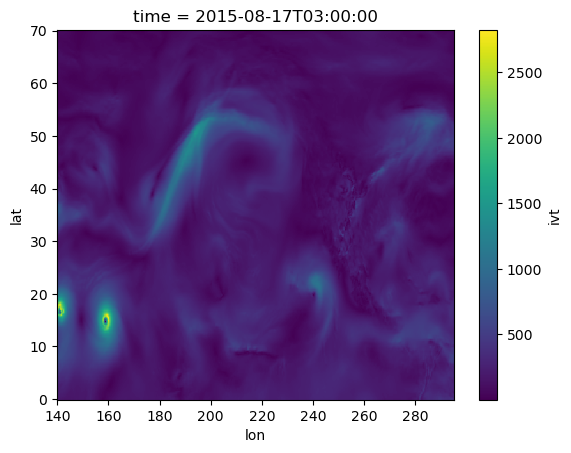

In [55]:
ds_IVT.isel(time=0).ivt.plot()

In [66]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()
ext1 = [-180., -120., 0, 70]

# Set tick/grid locations
lats = ds_IVT.lat.values
lons = ds_IVT.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round(),lats.max().round()+10,10)

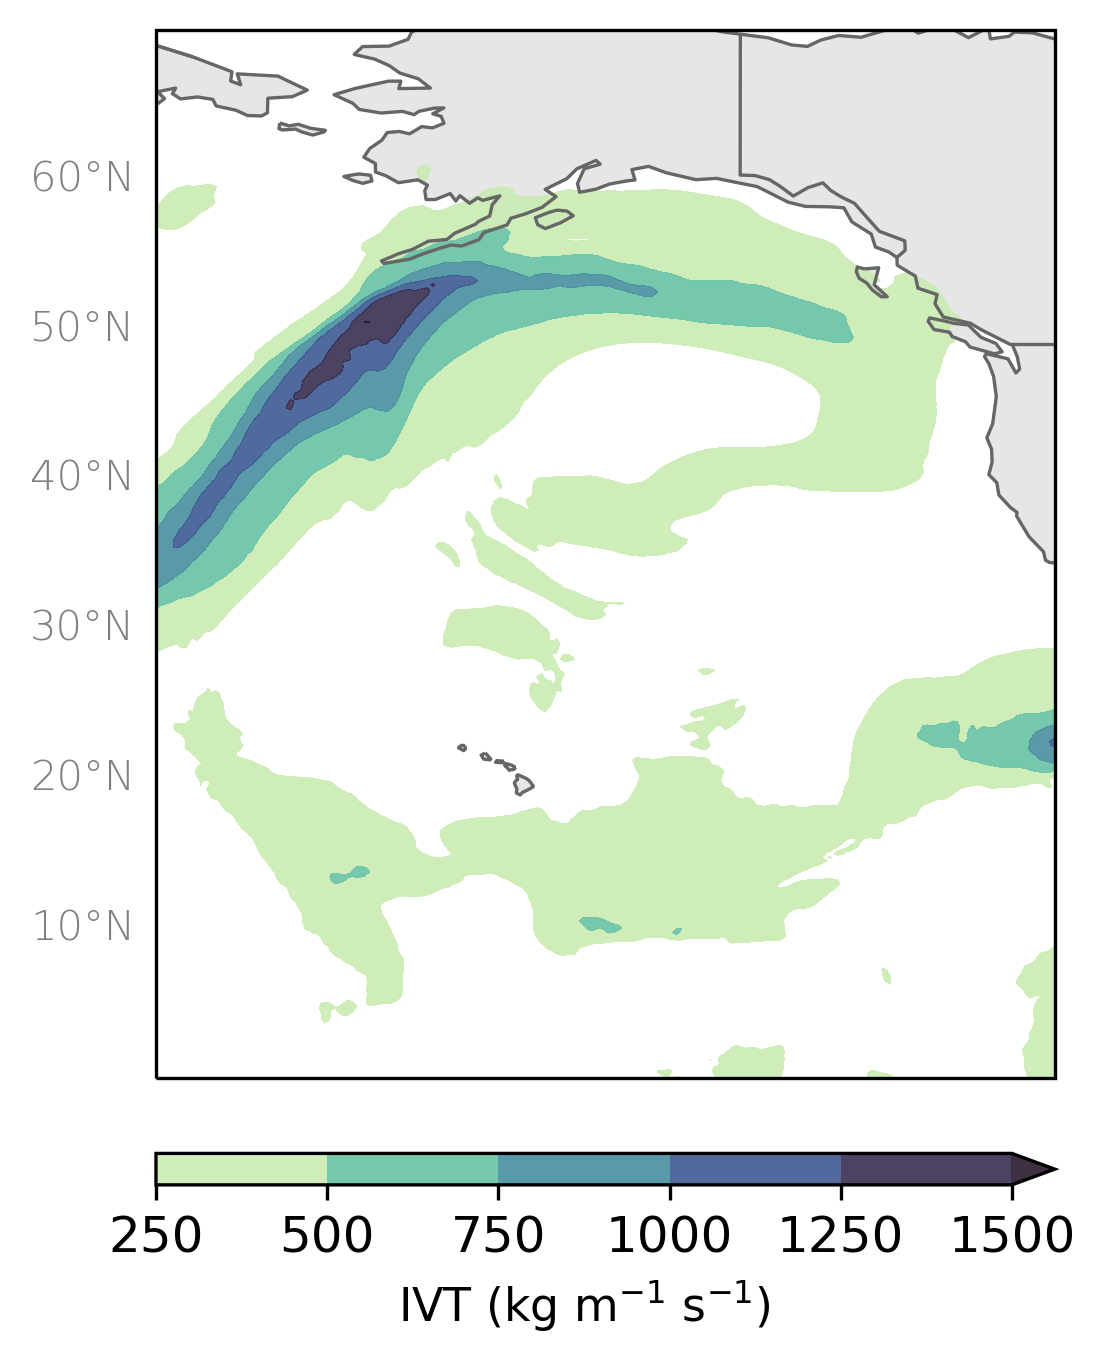

In [75]:
##### Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'test_IVT'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

############################
### IVT COMPOSITE ###
############################

for k, ax in enumerate(axgr):
    ds_plot = ds_IVT.isel(time=0)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

    # Contour Filled
    cflevs = np.arange(250, 1750, 250) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ds_plot.ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds_plot.ivtu*-1
    vvec = ds_plot.ivtv*-1

    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=2)

    # # quiver key
    # qk = ax.quiverkey(Q, 0.01, -0.025, 125, '125 kg m$^{-1}$ s$^{-1}$', labelpos='E',
    #                   coordinates='axes', fontproperties={'size': 6.0})

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()